### ODL - Group 1 : Binary Classification of Detecting Hypothyroid Disease

- Foo Lee Yi - TP054547
- Gun Ming Fai - TP056531
- Khor Zhen Win - TP055619
- Woon Eusean - TP055977


In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install sklearn
%pip install scipy
%pip install keras
%pip install tensorflow
%pip install keras-tuner

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Read Dataset


In [2]:
# set dataframe column display to show all columns
pd.set_option("display.max_columns", None)
# set dataframe row display to show all rows
pd.set_option("display.max_rows", None)

In [3]:
df1 = pd.read_csv("dataset/thyroidDF.csv")
df2 = pd.read_csv("dataset/hypothyroid.csv")

In [4]:
df1.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [5]:
df2.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,P


### Data Preprocessing


#### Renaming Columns to Merge Dataframes


In [6]:
# normalize df2 column name to snake_case
df2.columns = df2.columns.str.replace(" ", "_")

In [7]:
# check if normalized
# print column difference of df2 and df1
print(set(df2.columns) - set(df1.columns))
print(set(df1.columns) - set(df2.columns))
print(len(set(df2.columns) - set(df1.columns)))

{'on_antithyroid_medication', 'binaryClass'}
{'patient_id', 'target', 'on_antithyroid_meds'}
2


In [8]:
# normalize on_antithyroid_medication -> on_antithyroid_meds
# drop patient_id in df1
df1.drop("patient_id", axis=1, inplace=True)
df2.rename(
    columns={"on_antithyroid_medication": "on_antithyroid_meds"}, inplace=True)

In [9]:
# number of columns in df1 and df2
print(len(df1.columns))
print(len(df2.columns))

30
30


#### Extracting Binary Target in Multi-Level Target Variable


Letter Diagnosis For Target Variable

---

**hypothyroid conditions:** - 1

- E: hypothyroid
- F: primary hypothyroid
- G: compensated hypothyroid
- H: secondary hypothyroid

**everything else:** - 0


- A diagnosis of the form "XY" is interpreted as "consistent with X, but more likely Y"
- However, for consistency in preprocessing, we will treat "XY" as "X" and classes alike


In [10]:
# grouping of target column based on grouped levels defined
# 0 - "-",A,B,C,D,I,J,K,L,M,N,O,P,Q,R,S,T
# 1 - E,F,G,H


# define function to group target column
def group_target(x):
    # if x is anything but string, return 0
    if type(x) == int:
        return None
    else:
        # split x to get first character
        x = x[0]
        if x in ["E", "F", "G", "H"]:
            return 1
        if x == "-":
            return 0
        else:
            return None

<Axes: xlabel='target', ylabel='count'>

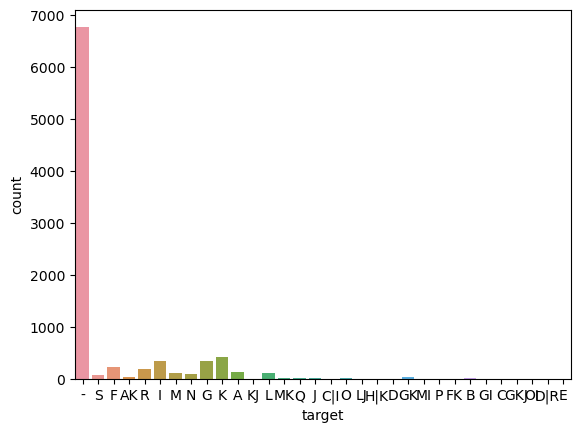

In [11]:
# plot barchart for distribution of "target" column
sns.countplot(x="target", data=df1)

In [12]:
# apply function to target column while remain int
df1["target"] = df1["target"].apply(group_target).astype("Int64")
# drop rows with "target" column having None values
df1.dropna(subset=["target"], inplace=True)
df1["target"].value_counts()

0    6771
1     667
Name: target, dtype: Int64

##### Labelling Target Variable For Second Dataset To Merge


Since this dataset is specifically for hypothyroid conditions

- "P" in the binaryClass will fall under Group 2
- "N" in the binaryClass will fall under Group 0


<Axes: xlabel='binaryClass', ylabel='count'>

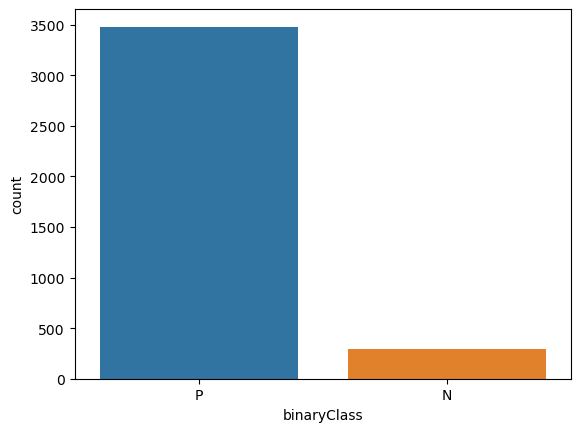

In [13]:
sns.countplot(x="binaryClass", data=df2)
# P - Positive Hypothyroid
# N - Negative Hypothyroid

In [14]:
# rename binaryClass to target and convert P to 2 and N to 0
df2.rename(columns={"binaryClass": "target"}, inplace=True)
df2["target"] = df2["target"].map({"P": 1, "N": 0})
df2["target"].value_counts()

1    3481
0     291
Name: target, dtype: int64

#### Merge Dataframes & Evaluate


In [15]:
# merge df1 and df2
df = pd.concat([df1, df2], axis=0)

In [16]:
print(df.shape)
df.head()

(11210, 30)


,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
0,29,F,f,f,f,f,f,f,f,t,f,f,f,f,f,f,t,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,0
1,29,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f,NaN,other,0
2,41,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,11.0,other,0
3,36,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,0
5,60,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t,26.0,other,0


In [17]:
# check for new target distribution
df["target"].value_counts()

0    7062
1    4148
Name: target, dtype: Int64

#### Check For Null Values


In [18]:
# check for null values in target variable
df["target"].isnull().sum()

0

In [19]:
# check for null values in other columns and print columns with null values
df.isnull().sum()[df.isnull().sum() > 0]

sex     237
TSH     690
T3     2173
TT4     354
T4U     673
FTI     666
TBG    7182
dtype: int64

In [20]:
# check for columns that contain "?" and count the rows for each column
for col in df.columns:
    if df[col][df[col] == "?"].count() > 1:
        print(col, df[col][df[col] == "?"].count())

sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


Columns may contain a string of "?" to signify missing values.

- Imputed with mean for float values
- Imputed with mode for categorical values


In [21]:
# create function to check if missing values >30% then drop the column, if not then impute with mean or mode
def drop_null_or_impute(df):
    for col in df.columns:
        missing_vals = df[col].isnull().sum(
        ) + df[col].loc[df[col] == "?"].count()
        if missing_vals > 0.3 * len(df):
            df.drop(col, axis=1, inplace=True)
        else:
            # if column is age, TSD, T3, TT4, T4U, FTI, TBG, impute with mean
            if col in ["age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG"]:
                # impute "?" to NaN, convert column to float, then impute with mean
                df[col] = df[col].replace("?", np.nan)
                df[col] = df[col].astype(float)
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                # if column is object, impute with mode after replacing "?" with NaN
                df[col] = df[col].replace("?", np.nan)
                df[col].fillna(df[col].mode()[0], inplace=True)
    return df

In [22]:
# drop columns with missing values >30%
df = drop_null_or_impute(df)
print(df.columns)
print(len(df.columns))
print(df.shape)

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'referral_source', 'target'],
      dtype='object')
29
(11210, 29)


In [23]:
# count the number of '?' in each column
for col in df.columns:
    print(col, df[col].loc[df[col] == "?"].count())

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_meds 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH_measured 0
TSH 0
T3_measured 0
T3 0
TT4_measured 0
TT4 0
T4U_measured 0
T4U 0
FTI_measured 0
FTI 0
TBG_measured 0
referral_source 0
target 0


#### Finding Out Variable Importance


##### Column Data Types


Float/Int Columns

- age, TSD, T3, TT4, T4U, FTI, TBG

Boolean Columns

- on_thyroxine, query_on_thyroxine, on_antithyroid_meds, sick, pregnant, thyroid_surgery, I131_treatment, query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, psych, TSH_measured, T3_measured, TT4_measured, T4U_measured, FTI_measured, TBG_measured

String Columns

- sex, referral_source, hypopituitary


In [24]:
# feature significance test libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# Kruskal-Wallis Test
from scipy.stats import kruskal

##### PreProcessing Numerical Variables - ANOVA Test


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'TSH'}>,
        <Axes: title={'center': 'T3'}>],
       [<Axes: title={'center': 'TT4'}>, <Axes: title={'center': 'T4U'}>,
        <Axes: title={'center': 'FTI'}>],
       [<Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

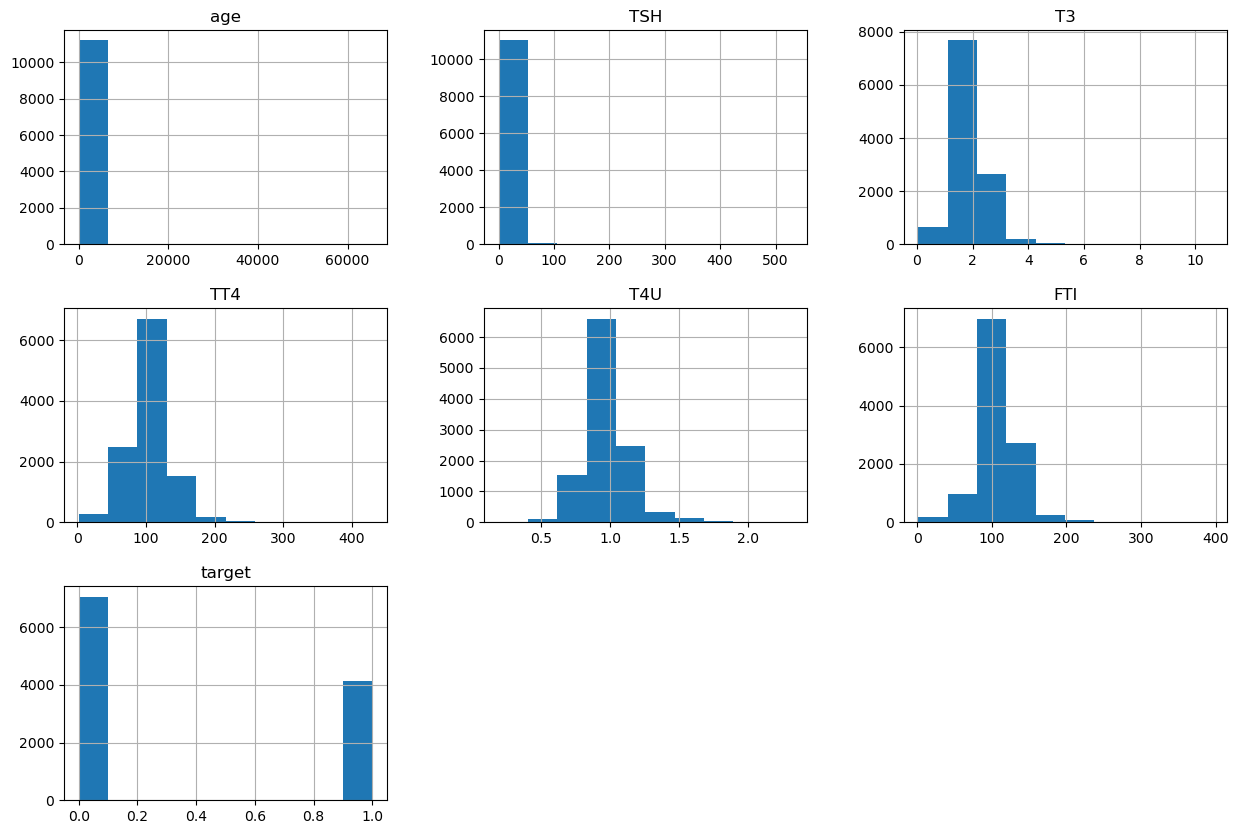

In [25]:
df.hist(bins=10, figsize=(15, 10))

In [26]:
# show statistical summary of float_columns
df.describe()

,age,TSH,T3,TT4,T4U,FTI,target
count,11210.000000,11210.000000,11210.000000,11210.000000,11210.000000,11210.000000,11210.0
mean,69.523329,5.460433,1.962648,104.583855,0.977050,108.421163,0.370027
std,1071.015861,24.507813,0.597513,30.003424,0.165748,28.034363,0.482833
min,1.000000,0.005000,0.050000,2.000000,0.190000,1.400000,0.0
25%,37.000000,0.680000,1.700000,88.000000,0.880000,94.000000,0.0
50%,55.000000,1.600000,1.962648,104.000000,0.977050,108.421163,0.0
75%,67.000000,3.800000,2.200000,120.000000,1.050000,121.000000,1.0
max,65526.000000,530.000000,10.600000,430.000000,2.320000,395.000000,1.0


##### Handle outliers for Age, TSH, TT4, FTI


In [27]:
# age, TSH, TT4, FTI columns have outliers that fall in illogical range

# check for number of rows with age > 100
print("Age")
print(df["age"][df["age"] > 100].count())

# check for number of rows with TSH > 20
print("TSH")
print(df["TSH"][df["TSH"] > 20].count())

# check for number of rows with TT4 > 250
print("TT4")
print(df["TT4"][df["TT4"] > 250].count())

# check for number of rows with FTI > 250
print("FTI")
print(df["FTI"][df["FTI"] > 250].count())

Age
5
TSH
402
TT4
17
FTI
21


In [28]:
# drop rows of outliers as number of rows is insignificant

# drop rows with age > 100
df.drop(df[df["age"] > 100].index, inplace=True)

# drop rows with TSH > 20
df.drop(df[df["TSH"] > 20].index, inplace=True)

# drop rows with TT4 > 250
df.drop(df[df["TT4"] > 250].index, inplace=True)

# drop rows with FTI > 250
df.drop(df[df["FTI"] > 250].index, inplace=True)

# check number of rows after dropping outliers
print(df.shape)

(10540, 29)


,age,TSH,T3,TT4,T4U,FTI,target
count,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.000000,10540.0
mean,51.904699,2.458676,1.980428,106.258329,0.974138,110.198670,0.354459
std,18.772345,2.741695,0.549791,26.207683,0.163307,23.618561,0.478372
min,1.000000,0.005000,0.050000,4.000000,0.190000,3.500000,0.0
25%,37.000000,0.650000,1.700000,90.000000,0.880000,96.000000,0.0
50%,55.000000,1.600000,1.962648,104.583855,0.977050,108.421163,0.0
75%,67.000000,3.300000,2.200000,120.000000,1.050000,122.000000,1.0
max,97.000000,20.000000,8.500000,250.000000,2.120000,249.000000,1.0


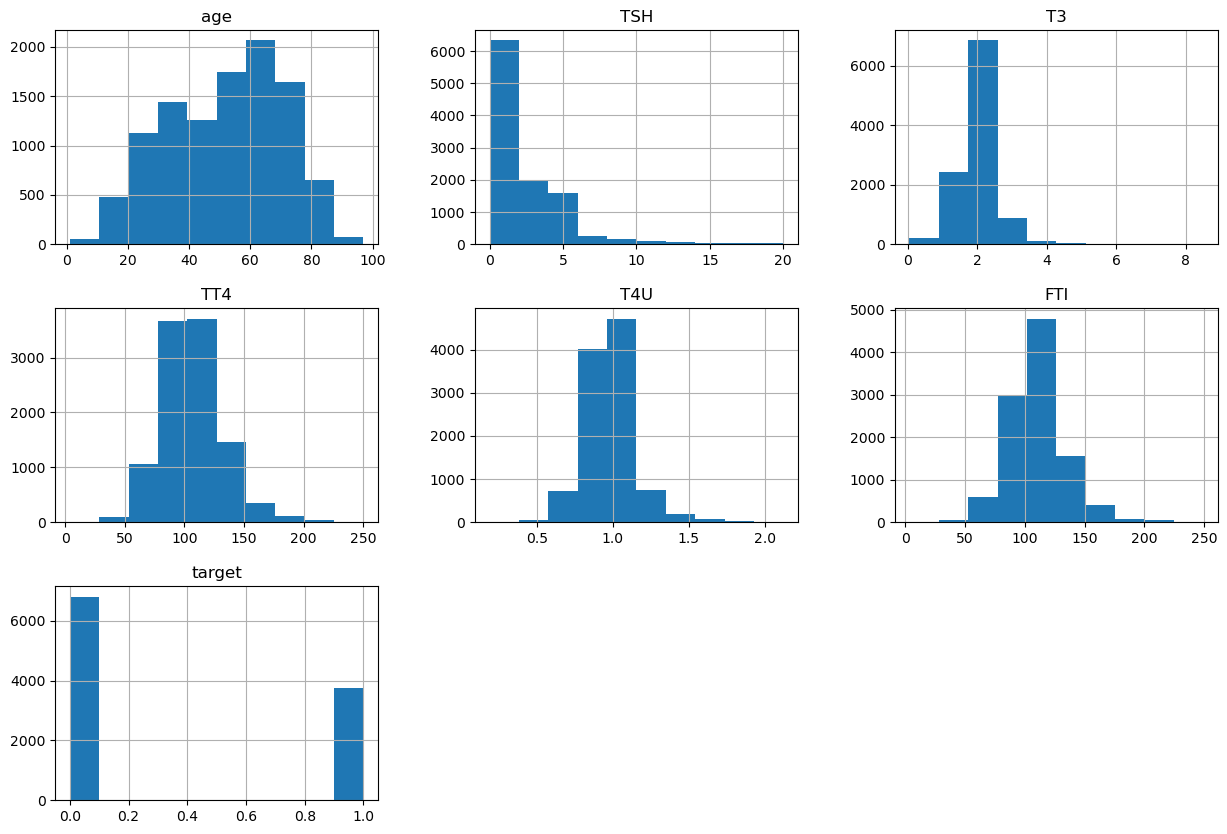

In [29]:
# re-examine statistical summary of float_columns and check for outliers
df.hist(bins=10, figsize=(15, 10))
df.describe()

In [30]:
#  f_classif test on numerical columns
float_columns = df.select_dtypes(include=["float", "int"])
# drop target from float_columns
float_columns.drop("target", axis=1, inplace=True)

anova_test = SelectKBest(score_func=f_classif, k="all")
anova_test.fit(float_columns, df["target"])

# create dataframe for with colums [column_name, f_classif_score, f_classif_p_value]
anova_score = pd.DataFrame(
    {
        "column_name": float_columns.columns,
        "f_classif_score": anova_test.scores_,
        "f_classif_p_value": anova_test.pvalues_,
    },
)

# sort dataframe by f_classif_p_value in ascending order
anova_score = anova_score.sort_values(
    by="f_classif_p_value", ascending=True
).reset_index(drop=True)

# determine significant columns based on f_classif_p_value < 0.05
anova_score["Significant"] = np.where(
    anova_score["f_classif_p_value"] < 0.05, True, False
)

anova_score

,column_name,f_classif_score,f_classif_p_value,Significant
0,TSH,151.698114,1.275692e-34,True
1,T4U,44.203018,3.106726e-11,True
2,TT4,16.360591,5.273602e-05,True
3,T3,2.689936,1.010137e-01,False
4,age,0.847229,3.573585e-01,False
5,FTI,0.017501,8.947562e-01,False


In [31]:
# drop T3 and age columns
df.drop(["T3", "age", "FTI"], axis=1, inplace=True)

##### PreProcessing Nominal Variables - Chi Square Test


In [32]:
#  chi2 test on boolean columns
from sklearn.preprocessing import LabelEncoder
nominal_columns = df.select_dtypes(include=["string", "object"])


# label encode nominal columns
le = LabelEncoder()
for col in nominal_columns.columns:
    nominal_columns[col] = le.fit_transform(nominal_columns[col])

In [33]:
#  chi2 test on binary columns
chi2_test = SelectKBest(score_func=chi2, k="all")
chi2_test.fit(nominal_columns, df["target"])

# create dataframe for with colums [column_name, chi2_score, chi2_p_value]
chi2_score = pd.DataFrame(
    {
        "column_name": nominal_columns.columns,
        "chi2_score": chi2_test.scores_,
        "chi2_p_value": chi2_test.pvalues_,
    },
)

# sort dataframe by f_classif_p_value in ascending order
chi2_score = chi2_score.sort_values(by="chi2_p_value", ascending=True).reset_index(
    drop=True
)

# determine significant columns based on f_classif_p_value < 0.05
chi2_score["Significant"] = np.where(
    chi2_score["chi2_p_value"] < 0.05, True, False)

chi2_score

,column_name,chi2_score,chi2_p_value,Significant
0,TBG_measured,131.995426,1.499643e-30,True
1,pregnant,28.009033,1.207505e-07,True
2,T3_measured,22.382133,2.234430e-06,True
3,lithium,8.932348,2.801640e-03,True
4,sex,3.391581,6.553008e-02,False
5,psych,2.371306,1.235836e-01,False
6,hypopituitary,1.821199,1.771706e-01,False
7,thyroid_surgery,0.877769,3.488136e-01,False
8,on_thyroxine,0.720637,3.959351e-01,False
9,query_on_thyroxine,0.706175,4.007166e-01,False


In [34]:
# keep only significant columns
df.drop(
    [
        "sex",
        "psych",
        "hypopituitary",
        "thyroid_surgery",
        "on_thyroxine",
        "query_on_thyroxine",
        "referral_source",
        "goitre",
        "I131_treatment",
        "TT4_measured",
        "FTI_measured",
        "T4U_measured",
        "query_hypothyroid",
        "sick",
        "on_antithyroid_meds",
        "TSH_measured",
        "query_hyperthyroid",
        "tumor",
    ],
    axis=1,
    inplace=True,
)

#### Evaluate New Dataset


In [35]:
df.shape

(10540, 8)

In [36]:
df.head()

,pregnant,lithium,TSH,T3_measured,TT4,T4U,TBG_measured,target
0,f,f,0.300000,f,104.583855,0.97705,f,0
1,f,f,1.600000,t,128.000000,0.97705,f,0
2,f,f,5.460433,f,104.583855,0.97705,t,0
3,f,f,5.460433,f,104.583855,0.97705,t,0
5,f,f,5.460433,f,104.583855,0.97705,t,0


In [37]:
df.describe()

,TSH,TT4,T4U,target
count,10540.000000,10540.000000,10540.000000,10540.0
mean,2.458676,106.258329,0.974138,0.354459
std,2.741695,26.207683,0.163307,0.478372
min,0.005000,4.000000,0.190000,0.0
25%,0.650000,90.000000,0.880000,0.0
50%,1.600000,104.583855,0.977050,0.0
75%,3.300000,120.000000,1.050000,1.0
max,20.000000,250.000000,2.120000,1.0


array([[<Axes: title={'center': 'TSH'}>, <Axes: title={'center': 'TT4'}>],
       [<Axes: title={'center': 'T4U'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

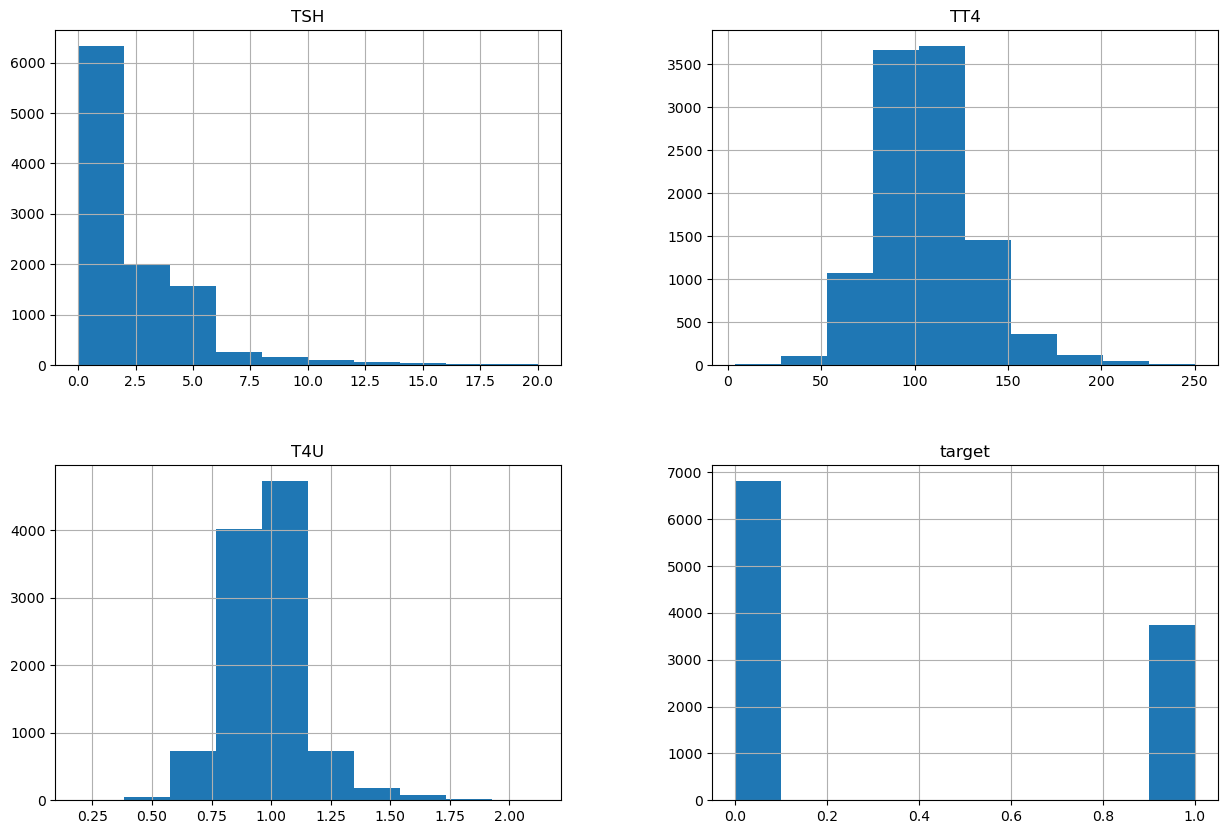

In [38]:
df.hist(bins=10, figsize=(15, 10))

### Output New Dataset


In [39]:
# output cleaned data to csv
df.to_csv("./dataset/cleaned_data.csv", index=False)

### Split Into Train and Test Sets With Oversampling


In [40]:
# label encode categorical columns
from sklearn.preprocessing import LabelEncoder

df_encode = df.copy(deep=True)

le = LabelEncoder()
for col in df_encode.columns:
    if df_encode[col].dtype == "object":
        df_encode[col] = le.fit_transform(df_encode[col])

In [41]:
# split into train and test sets without splitting X and y
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_encode, test_size=0.2, random_state=42)

print("Train : " + str(train.shape))
print("Test : " + str(test.shape))

Train : (8432, 8)
Test : (2108, 8)


In [42]:
# check levels of target in Train set
train["target"].value_counts()

0    5439
1    2993
Name: target, dtype: Int64

In [44]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# split train set to X and y
X_train = train.drop("target", axis=1)
y_train = train["target"].astype("int")

# apply SMOTE only to training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# check the class distribution of the target variable Churn before and after oversampling

print("Before oversampling: ", Counter(y_train))
print("After oversampling: ", Counter(y_train_smote))

Before oversampling:  Counter({0: 5439, 1: 2993})
After oversampling:  Counter({0: 5439, 1: 5439})


In [45]:
# merge back X_train_smote and y_train_smote into train_smote
train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)
train_smote.head()

,pregnant,lithium,TSH,T3_measured,TT4,T4U,TBG_measured,target
0,0,1,1.70,1,120.0,1.18,0,0
1,0,0,1.20,1,95.0,1.10,0,1
2,0,0,1.40,1,130.0,0.93,0,1
3,0,0,0.08,0,142.0,0.93,0,0
4,0,0,1.90,0,123.0,1.16,0,0


In [46]:
# save train_smote and test to csv
train_smote.to_csv("./dataset/train.csv", index=False)
test.to_csv("./dataset/test.csv", index=False)